In [276]:
using Distributions
using PyCall
using PyPlot
using DelimitedFiles
using LinearAlgebra
using Random
using SparseArrays
using StatsBase
using QuadGK
using SpecialFunctions

In [277]:
# Read in relevant model parameters
include("src_rate/param.jl");

# Initialize recurrent weights

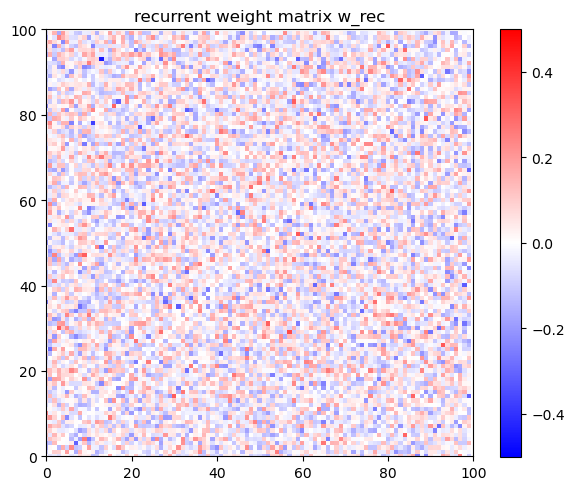

In [278]:
include("src_rate/genWeights.jl") 
w_rec = genWeights(p.Ncells,0,1)/sqrt(p.Ncells) #divide by sqrt(p.Ncells)?
w_rec_init = copy(w_rec) # save a copy of the initialized recurrent weights

# Plot recurrent weight matrix
fig, ax = subplots(figsize=(6, 6))

# Custom normalization centered at 0
norm = matplotlib.colors.CenteredNorm(vcenter=0, halfrange=0.5)
cax = ax.imshow(w_rec, cmap="bwr", norm=norm)
colorbar(cax, shrink=0.75)

xlim(0,p.Ncells)
ylim(0,p.Ncells)
title("recurrent weight matrix w_rec")

# Show plot
tight_layout()
show()

# Generate target rates

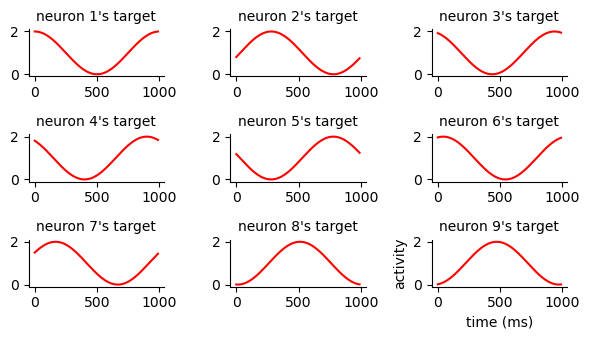

In [279]:
include("src_rate/generate_target_rates.jl") 
r_targ = generate_target_rates(p)

# show target activity patterns
figure(figsize=(6,3.5))
for ci = 1:9
    ax = subplot(3,3,ci)
    plot(r_targ[Int((p.stim_off+1)/p.dt):end,ci], c="r")
    title("neuron $(ci)'s target", fontsize=10)
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
end
xlabel("time (ms)")
ylabel("activity")
tight_layout()
#savefig("figure/target.pdf")
PyPlot.display_figs()

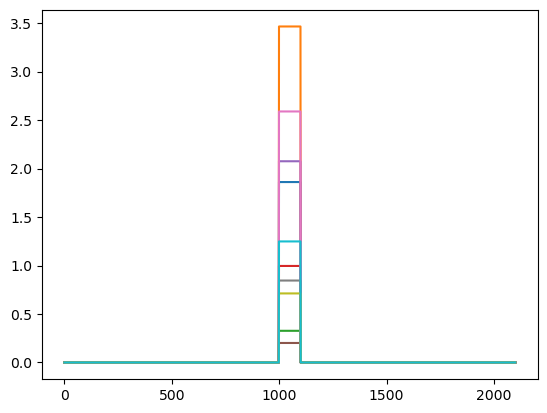

10-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x38f05f9b0>
 PyObject <matplotlib.lines.Line2D object at 0x38f077c80>
 PyObject <matplotlib.lines.Line2D object at 0x38f077d70>
 PyObject <matplotlib.lines.Line2D object at 0x38f077e60>
 PyObject <matplotlib.lines.Line2D object at 0x38f077f50>
 PyObject <matplotlib.lines.Line2D object at 0x38f09c050>
 PyObject <matplotlib.lines.Line2D object at 0x38f09c140>
 PyObject <matplotlib.lines.Line2D object at 0x38f09c230>
 PyObject <matplotlib.lines.Line2D object at 0x38f09c320>
 PyObject <matplotlib.lines.Line2D object at 0x38f09c3e0>

In [280]:
# define stimulus to trigger response in cells
scalar = 2
stim = 2*(2*rand(Int(p.Ncells))); #generate stimulus magnitudes for each cell
#stim = scalar * LogNormal(0, 1)

I_ext = zeros(p.Nsteps,p.Ncells) #initialize external input 
for ti = 1:p.Nsteps
    #set external input
    if ti >= Int(p.stim_on/p.dt) && ti <= Int(p.stim_off/p.dt)
            I_ext[ti,:] .= stim;
    else
            I_ext[ti,:] .= 0
    end
end

plot(I_ext[1:end,1:10]) #display external stimulus to a subset of cells prior to training 

# Simulate and train a network of rate neurons

In [281]:
# import functions required for training
include("src_rate/activation_functions.jl") #Loads activation function called as F.
include("src_rate/rls_train.jl")

rls_train (generic function with 2 methods)

In [282]:
# main training function

function train_rate_model(p,w_rec,I_ext)
  
  # Set parameters and initialize  
  x = zeros(p.Nsteps,p.Ncells) #initialize total input to each cell
  r = zeros(p.Nsteps,p.Ncells) #initialize output rate for each cell
  wr = zeros(p.Nsteps,p.Ncells)

    # Initialize regularized inverse correlation matrix
    p.penlambda = 0.5
    P = Dict{Int64,Array{Float64,2}}()
    Px = Dict{Int64, Vector{Int64}}() 
    for ci=1:Ncells
        ci_prenum = sum(w_rec[ci,:].!=0);
        ci_preind = w_rec[ci,:].!=0;   
        P[ci] = (1.0 / p.penlambda) * I(ci_prenum)  # Using the identity matrix function I(n) instead of eye
        Px[ci] = findall(ci_preind);
    end
    
  for iloop =1:p.nloop
    println("Loop no. ",iloop)

    start_time = time()

    #compute rate timecourse
    for ti = 2:p.Nsteps
   
        x[ti-1,:] .= w_rec * r[ti-1,:] .+ I_ext[ti,:] # calculate total input to each neuron (recurrent + external)
                 
        
        dr = p.dt/p.tau .* (-r[ti-1,:] .+ F(x[ti-1,:], p)) # calculate incremental change in rate dr at timestep ti
        #dr = p.dt/p.tau .* (-r[ti-1,:] .+ w_rec * F(r[ti-1,:], p))
        
        r[ti,:] = r[ti-1,:] .+ dr # update rate for each neuron
        wr[ti,:] = w_rec * r[ti,:] #Compute the training variable

        if ti > Int(p.stim_off/dt)+1 && mod(ti, p.learn_every/p.dt) == 0        

           w_rec, P, wr = rls_train(ti, p, r, r_targ, P, Px, w_rec, wr) # apply learning rule to recursively update weights and the per-cell inverse correlation matrix
                   
        end

    end

    # calculate the time for each training loop and assess average correlation between target and output
    elapsed_time = time()-start_time
    correlations = [cor(r_targ[Int(p.stim_off+1/p.dt):end,ci], wr[Int(p.stim_off+1/p.dt):end,ci]) for ci in 1:p.Ncells]
    println("elapsed time: ",elapsed_time, " corr=", mean(correlations))
        
  end

  return r, w_rec, wr

end

train_rate_model (generic function with 1 method)

In [283]:
r, w_rec, wr = train_rate_model(p, w_rec, I_ext)

Loop no. 1
elapsed time: 0.04091286659240723 corr=0.8953510557924441
Loop no. 2
elapsed time: 0.04375600814819336 corr=0.9143649783797323
Loop no. 3
elapsed time: 0.04308319091796875 corr=0.9727426664862479
Loop no. 4
elapsed time: 0.0434877872467041 corr=0.9552307974709856
Loop no. 5
elapsed time: 0.056405067443847656 corr=0.9781936485594739
Loop no. 6
elapsed time: 0.046331167221069336 corr=0.9682797911063293
Loop no. 7
elapsed time: 0.04457402229309082 corr=0.975416636153518
Loop no. 8
elapsed time: 0.04342985153198242 corr=0.9758042310114793
Loop no. 9
elapsed time: 0.04770803451538086 corr=0.974842722803628
Loop no. 10
elapsed time: 0.051724910736083984 corr=0.9748826423196705
Loop no. 11
elapsed time: 0.035659074783325195 corr=0.9747235071917565
Loop no. 12
elapsed time: 0.04655885696411133 corr=0.9746081405877061
Loop no. 13
elapsed time: 0.048857927322387695 corr=0.9748233573369999
Loop no. 14
elapsed time: 0.05038905143737793 corr=0.9750406146660865
Loop no. 15
elapsed time: 0

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 1.681896606442585 0.3819641093942254 … 1.6228177400616939 1.7972664932659934; 1.6850044051695325 0.38560042640656916 … 1.6192218887352257 1.7989834058486476], [0.0 -0.04566228529108798 … 0.061220192861030254 -0.0471528496839948; -0.090715829146115 0.0 … -0.044713978755717004 -0.007619967835004967; … ; -0.1757564391497914 -0.0036097815468359696 … 0.0 -0.09360768103335523; -0.0504310294208518 0.03354609936445459 … 0.11990865251688931 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 1.992676479137323 0.7455958106286017 … 1.2632326074148637 1.9689577515314065; 1.993063403013074 0.7516671494622632 … 1.25718212285941 1.9675064272713467])

# Compare per-cell agreement between trained rates and target activity

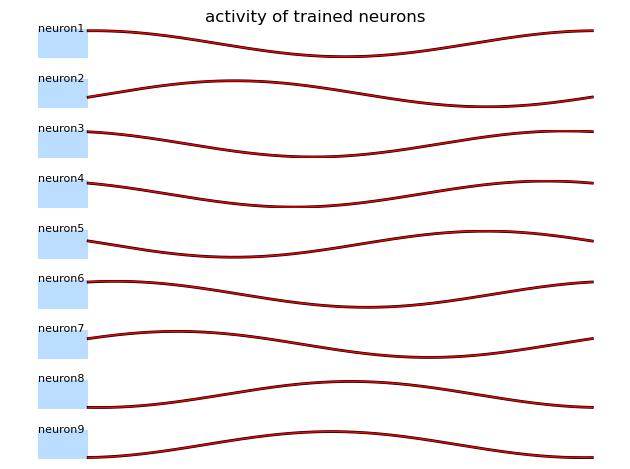

In [285]:
beg_train = Int(p.stim_off/p.dt)+1
stop_train = Int(p.train_time/p.dt)
for ci = 1:9
    subplot(9,1,ci)

    axvspan(-(p.stim_off/p.dt-p.stim_on/p.dt), 0, color="dodgerblue", alpha=0.3, ec="None")
    plot(wr[beg_train:stop_train,ci], lw=2, color="black", label="output")
    plot(r_targ[beg_train:stop_train,ci], lw=1, color="red", label="target")
    annotate("neuron$(ci)", ((p.stim_off/p.dt)-1200,2.0), fontsize=8)
    
    if ci ==1
        title("activity of trained neurons")
        #legend(frameon=false, bbox_to_anchor=(1.2, 1.05),loc="upper right")      
    end
    axis("off")
end
tight_layout()
PyPlot.display_figs()



# Visualize change in trained weights

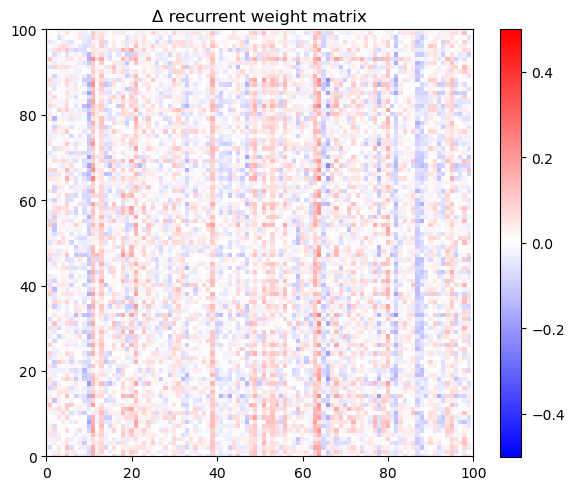

In [286]:
# Plot recurrent weight matrix
fig, ax = subplots(figsize=(6, 6))

delta_w_rec = w_rec .- w_rec_init

# Custom normalization centered at 0
norm = matplotlib.colors.CenteredNorm(vcenter=0, halfrange=0.5)
cax = ax.imshow(delta_w_rec, cmap="bwr", norm=norm)
colorbar(cax, shrink=0.75)

xlim(0,p.Ncells)
ylim(0,p.Ncells)
title("Δ recurrent weight matrix")

# Show plot
tight_layout()
show()